# LSTM Prediction ans Simple Trading

# Table of Contents

- [Problem Definition](#Problem-Definition)
- [Dataset](#Dataset)
- [Feature Engineering](#Feature-Engineering)
	- [Technical Indicators](#Technical-Indicators)
	- [Example Data](#Example-Data)
	- [Data Scaling](#Data-Scaling)
	- [Time Window Conversion](#Time-Window-Conversion)
- [Modeling](#Modeling)
	- [Hyperparameters](#Hyperparameters)
	- [Learning Curves](#Learning-Curves)
	- [Metrics Comparison](#Metrics-Comparison)
- [Analysis and Prediction](#Analysis-and-Prediction)
	- [Model Prediction](#Model-Prediction)
	- [Prediction Result](#Prediction-Result)
- [Stock Trading](#Stock-Trading)
	- [Trading Strategy](#Trading-Strategy)
	- [Trading Performance](#Trading-Performance)
	- [Backtest](#Backtest)

## Problem Definition

The project target is to use machine learning method to investigate the applying possibility of market trading.

In LSTM Prediction and Simple Trading subproject, here we discuss a simple approach use general Deep Learning method to predict market and apply the prediction result to a simple trading strategy to evaluate the portfolio performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from pprint import pprint
import itertools
import seaborn as sns
import tkinter
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
from tensorflow.keras.losses import LogCosh, Huber

import IPython
import IPython.display

%matplotlib inline
from rl.config import config
from rl.marketdata.yahoodownloader import YahooDownloader
from rl.preprocessing.preprocessors import FeatureEngineer
from rl.preprocessing.data import data_split
from rl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
pd.set_option('display.max_columns', None)

## Dataset

Here is the dataset configuration:

In [4]:
# from config.py start_date is a string
start_date = config.START_DATE
# from config.py end_date is a string
end_date = config.END_DATE
# from config.py split_date is a string
split_date = config.SPLIT_DATE
# config target ticker
target_ticker = config.SP500_20_TICKER.copy()
target_ticker.extend(['SPY'])
# config tech_indicator_list
tech_indicator_list = config.TECHNICAL_INDICATORS_LIST
print("training period: {}-{}, testing period: {}-{}\n".format(start_date, split_date, split_date, end_date))
print("target ticker list:\n {}\n".format(target_ticker))
print("tech_indicator_list:\n {}\n".format(tech_indicator_list))

training period: 2000-01-01-2019-01-01, testing period: 2019-01-01-2021-01-01

target ticker list:
 ['AAPL', 'MSFT', 'AMZN', 'BRK-B', 'JPM', 'JNJ', 'UNH', 'HD', 'PG', 'NVDA', 'DIS', 'BAC', 'CMCSA', 'XOM', 'VZ', 'T', 'ADBE', 'PFE', 'CSCO', 'INTC', 'SPY']

tech_indicator_list:
 ['macd', 'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30', 'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema', 'close_60_ema', 'close_120_ema']



In [5]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = target_ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0


## Feature Engineering

### Add Technical Indicators

The feature engineering step would general technical indicators according to the original ticker's information. 

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicator_list,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

processed.head()

Successfully added technical indicators
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_10,rsi_20,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.859423,535796800.0,AAPL,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,16.812500,16.875000,16.062500,16.274673,7384400.0,ADBE,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,81.500000,89.562500,79.046875,89.375000,16117600.0,AMZN,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,25.125000,25.125000,24.000000,13.952057,13705800.0,BAC,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,36.500000,36.580002,34.820000,35.299999,875000.0,BRK-B,0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0


In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)

processed_full.sort_values(['date','tic'], ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_10,rsi_20,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
0,2000-01-03,AAPL,0.936384,1.004464,0.907924,0.859423,535796800.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,0.859423,0.859423,0.859423,0.859423,0.859423,0.859423,0.0
1,2000-01-03,ADBE,16.812500,16.875000,16.062500,16.274673,7384400.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,16.274673,16.274673,16.274673,16.274673,16.274673,16.274673,0.0
2,2000-01-03,AMZN,81.500000,89.562500,79.046875,89.375000,16117600.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,89.375000,89.375000,89.375000,89.375000,89.375000,89.375000,0.0
3,2000-01-03,BAC,25.125000,25.125000,24.000000,13.952057,13705800.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,13.952057,13.952057,13.952057,13.952057,13.952057,13.952057,0.0
4,2000-01-03,BRK-B,36.500000,36.580002,34.820000,35.299999,875000.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,35.299999,35.299999,35.299999,35.299999,35.299999,35.299999,0.0
5,2000-01-03,CMCSA,16.145832,16.333332,15.062500,12.189544,2333700.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,12.189544,12.189544,12.189544,12.189544,12.189544,12.189544,0.0
6,2000-01-03,CSCO,54.968750,55.125000,51.781250,40.118656,53076000.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,40.118656,40.118656,40.118656,40.118656,40.118656,40.118656,0.0
7,2000-01-03,DIS,28.855125,29.533344,28.361876,23.115248,8402230.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,23.115248,23.115248,23.115248,23.115248,23.115248,23.115248,0.0
8,2000-01-03,HD,68.625000,69.187500,63.812500,42.563168,12030800.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,42.563168,42.563168,42.563168,42.563168,42.563168,42.563168,0.0
9,2000-01-03,INTC,41.632812,43.687500,41.625000,27.002798,57710200.0,0.0,0.0,0.925665,0.720723,0.0,0.0,-66.666667,-66.666667,100.0,27.002798,27.002798,27.002798,27.002798,27.002798,27.002798,0.0


### Example Data

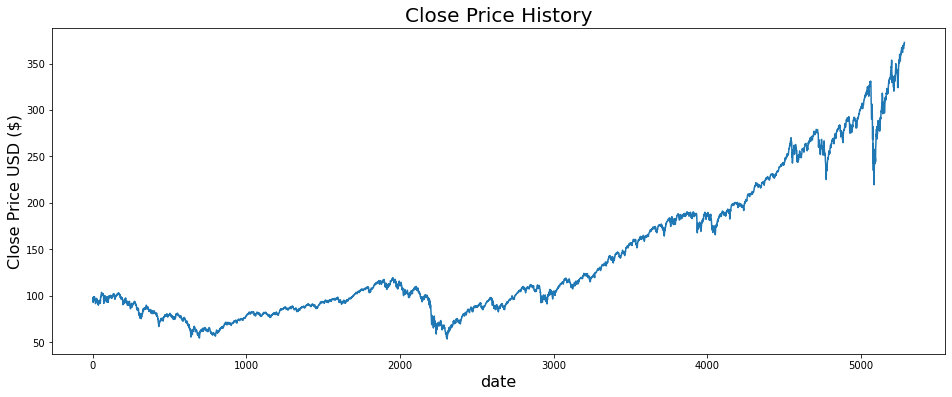

In [9]:
SPY=processed_full[processed_full['tic']=='SPY']
SPY=SPY.reset_index(drop=True)

%matplotlib inline

plt.figure(figsize=(16,6))
plt.title('Close Price History', fontsize=20)
plt.plot(SPY['close'])
plt.xlabel('date', fontsize=16)
plt.ylabel('Close Price USD ($)', fontsize=16)
plt.show()

### Data Scaling

#### Logarithmic Conversion

During our previous training experience, we found many stock cannot fit well as the price goes high, but in historical pricing range, the directly trained model works acceptable. And then, we look back to the original dataset, there are some concerns training historical data to predict future.
- the future price generally growth as company and total market growth, using the historical price related feature predict future somehow like using data predict out of training feature space points. As well as other patterns may only exist in near months dataset. Our solution is adopt rolling prediction method to predict future (in this project is 2019-01-01 to 2021-01-01) with near months data.  

Selected the close price from above example ticker, we could make some simple fit with linear and no-linear regression as following.   

Obviously, the sp index pricing follow the expenitial tendency, same as pricing direvative technical indicator.   

- the total market price increase more close to expnential than linear as following shows, if we could convert the no-linear data to a easier acceptable data by Deep Nerual Network, it would help to boost the model performance.

In [10]:
def linear_polyfit(ticker, ):
    coefficients=np.polyfit(np.array(range(len(ticker))), np.array(ticker['close']), 1)
    poly = np.poly1d(coefficients)
    poly_x = np.array(range(len(SPY)))
    poly_y = poly(poly_x)
    return poly_x, poly_y

def exp_polyfit(ticker, ):
    coefficients=np.polyfit(np.array(range(len(ticker))), np.log(np.array(ticker['close'])), 1)
    poly = np.poly1d(coefficients)
    poly_x = np.array(range(len(SPY)))
    poly_y = np.exp(poly(poly_x))
    return poly_x, poly_y

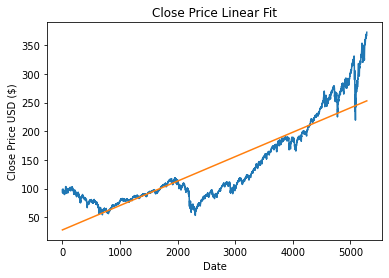

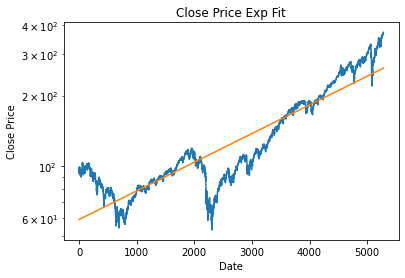

In [11]:
%matplotlib inline

_, poly_y = linear_polyfit(SPY)
plt.figure()
plt.title('Close Price Linear Fit')
plt.plot(SPY['close'], label='close_price')
plt.plot(poly_y, label='linear_fit')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

_, poly_y = exp_polyfit(SPY)
plt.figure()
plt.title('Close Price Exp Fit')
plt.plot(SPY['close'], label='close_price')
plt.plot(poly_y, label='log_fit')
plt.xlabel('Date')
plt.yscale("log")
plt.ylabel('Close Price')
plt.show()

Here are several feature columns could be logarithmic convert.

In [12]:
# log convert price related values
log_feature_columns = ['close', 'open', 'high', 'low', 'boll_ub', 'boll_lb',
       'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema',
       'close_60_ema', 'close_120_ema']

def log_convert(data, log_feature_columns):
    return data.apply(lambda x: np.log(x) if x.name in log_feature_columns else x)

processed_full=log_convert(processed_full, log_feature_columns)

In [172]:
len(SPY)

5284

In [177]:
SPY[SPY['date']=='2020-12-31']

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_10,rsi_20,cci_10,cci_20,dx_30,close_20_sma,close_60_sma,close_120_sma,close_20_ema,close_60_ema,close_120_ema,turbulence
5283,2020-12-31,SPY,371.779999,374.660004,371.230011,372.659454,78520700.0,3.0,3.953809,372.629176,361.515288,70.903466,65.323094,105.368123,159.113762,43.796707,367.072232,353.564373,342.006158,366.400775,355.331731,342.473709,6.605555


#### Scaling Conversion

In [13]:
# Training feature_columns
feature_columns = ['close', 'open', 'high', 'low', 'volume', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_10', 'rsi_20', 'cci_10', 'cci_20', 'dx_30',
       'close_20_sma', 'close_60_sma', 'close_120_sma', 'close_20_ema',
       'close_60_ema', 'close_120_ema', 'turbulence']

In [14]:
def scale_df(df, feature_columns):
    tics = df.tic.unique()
    scalers = {}
    dataset = {}
    scaled_dataset = {}
    for tic in tics:
        dataset[tic] = df[df['tic']==tic].filter(feature_columns).values
        # Most of stock long term increase, so here may have some skew, reserve the range not full.
        scalers[tic] = MinMaxScaler(feature_range=(0.2,0.8))
        scaled_dataset[tic] = scalers[tic].fit_transform(dataset[tic])
    return scalers, dataset, scaled_dataset
scalers, dataset, scaled_dataset = scale_df(processed_full, feature_columns)

### Time Window Conversion

Our target is convert original data to a continuous time series dataset. Here is the time series slices parameters define. The original data would be convert to continuous time slice dataset

In [183]:
# Time Series Data Hyperparameter Define:
shift = 1 # the target y offset from last x time series gap
input_width = 90 # the x input time windows width, per quarter
train_idx = 4778 # get date from 2000-01-01 to 2018-12-31

In [184]:
# Create the training data set 
# Create the scaled training data set
# Split the data into x_train and y_train data sets
def data_window_split(df, train_idx, input_width, shift):
    """
    Split dataset to time series windows
    df: data frame
    train_len: training dataset length
    input_width: training time series length
    shift: offset between x and y
    """
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for i in range(input_width - 1, len(df) - shift): # i is the last pos of input x
        if i < train_idx:
            x_train.append(df[i - input_width + 1: i + 1, :])
            y_train.append(df[i + shift, 0])
        else:
            x_test.append(df[i - input_width + 1: i + 1, :])
            y_test.append(df[i + shift, 0])
    
    x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    return x_train, y_train, x_test, y_test

def data_prepare(full_stock_data, train_idx, input_width, shift):
    """
    data_prepare: prepare dataset by ticker.
    """
    x_train_dict = {}
    y_train_dict = {}
    x_test_dict = {}
    y_test_dict = {}
    for k in full_stock_data.keys():
        data = full_stock_data[k]
        x_train_dict[k], y_train_dict[k], x_test_dict[k], y_test_dict[k] = data_window_split(data, train_idx, input_width, shift)
        
        print(k, '\t', x_train_dict[k].shape, y_train_dict[k].shape, x_test_dict[k].shape, y_test_dict[k].shape)
    return x_train_dict, y_train_dict, x_test_dict, y_test_dict

x_train_dict, y_train_dict, x_test_dict, y_test_dict = data_prepare(scaled_dataset, train_idx, input_width, shift)

AAPL 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
ADBE 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
AMZN 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
BAC 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
BRK-B 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
CMCSA 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
CSCO 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
DIS 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
HD 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
INTC 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
JNJ 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
JPM 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
MSFT 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
NVDA 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
PFE 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
PG 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
SPY 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
T 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
UNH 	 (4689, 90, 21) (4689,) (505, 90, 21) (505,)
VZ 	 (4689, 90, 21) (4689,) (505, 90, 21) (

## Modeling

### Baseline Model

#### Hyperparameters

In Hyperparameters searching, we try different model units, dropout rate, loss function, batch sizes, and if train in single stock per epoch or shuffle train all.

- Units: units use 256 LSTM, 256 LSTM, 32 Dense, 1 Dense could give a relatively stable loss gradient descent.

- dropout: if LSTM and Dense value not too large and consider the calculation resources' limitation, a better choice is don't dropout. The advantage is the NN could converge to a relative stable state fastly, and provent overfit by epoch estimate.

- loss function: we tried several losses, a more reasonable loss is mean_absolute_percentage_error, the reason behind it is that in the market, our target is to fit the predict price to real price. Using percentage to represent predict result and real value relationship is more accuracy. For example, in 2000, AAPL price close to \\\$1.0, but in 2020 AAPL share price close to \\\$200.0, we hope to evenly fit the prediction to the real value instead of more sensitive in large number. In this scenario, the mean percentage error is ideally to use. And if considering the linear and derivative, maybe we could build our own loss at next step, to let the loss more smooth and linear derivatable when close to 0.

- batch size: batch size would influence the model training speed as we hope to fully use GPU resource at each batch, but at the same time, if batch size too large, it would also cannot capture tiny pattern.

- Single Stock or All stocks: build model for each stock, or train model on stock by stock, or shuffle data and train together is another potential optmized point. In the hyperparameters searching, All stock shuffle train performance is better. And if hope to predict single stock we could also retrain model for specific one.


In [17]:
units_option=[
    [128, 128, 32], 
    [256, 256, 64], 
    [512, 512, 64], 
]
units=[256,256,32]
dropout_option=[None,0.2]
dropout=None
loss_option=['mean_squared_error', 'mean_absolute_percentage_error', 'huber_loss', 'log_cosh']
loss='mean_absolute_percentage_error'
batch_size_option=[32, 128]
batch_size=128
tic_option=['SPY', 'ALL']
tic='ALL'
epochs=5

In [18]:
def merge_tic(x_dict, y_dict):
    """
    Merge Tickers to one dataset
    """
    x = np.concatenate(tuple(x_dict.values()), axis=0)
    y = np.concatenate(tuple(y_dict.values()), axis=0)
    return x, y

# Build the LSTM model
def build_simple_lstm(units, dropout=None, optimizer='adam', loss='mean_squared_error'):
    model = Sequential()
    model.add(LSTM(units[0], return_sequences=True, input_shape=(input_width, len(feature_columns))))
    if dropout and dropout > 0.0:
        model.add(Dropout(rate=dropout))
    model.add(LSTM(units[1], return_sequences=False))
    if dropout and dropout > 0.0:
        model.add(Dropout(rate=dropout))
    model.add(Dense(units[2]))
    if dropout and dropout > 0.0:
        model.add(Dropout(rate=dropout))
    model.add(Dense(1))
    model.compile(
        optimizer=optimizer, loss=loss, metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanAbsolutePercentageError(), tf.metrics.MeanSquaredError()]
    )
    return model

def model_fit(
    x_train, 
    y_train, 
    model, 
    batch_size=1, 
    epochs=1, 
    validation_split=0.1,
    shuffle_split=True,
):
    if shuffle_split:
        x_train, y_train = shuffle(x_train, y_train)
    history = model.fit(
        x_train, 
        y_train, 
        batch_size = batch_size, 
        epochs=epochs, 
        validation_split=validation_split,
        verbose=1
    )
    return history

def model_fit_merge_tic(
    x_train_dict, 
    y_train_dict, 
    model, 
    batch_size=1, 
    epochs=1, 
    validation_split=0.1,
    shuffle_split=True,
):
    x_train, y_train = merge_tic(x_train_dict, y_train_dict)
    if shuffle_split:
        x_train, y_train = shuffle(x_train, y_train)
    history = model.fit(
        x_train, 
        y_train, 
        batch_size = batch_size, 
        epochs=epochs, 
        validation_split=validation_split,
        verbose=1
    )
    return history

def model_fit_per_tic(x_train_dict, y_train_dict, model, batch_size=1, epochs=1, validation_split=0.1, shuffle_split=True,):
    loss_r=[]
    val_loss_r=[]
    for i in range(epochs):
        print("======== epochs: {} ========".format(i))
        loss = []
        val_loss = []
        for k in x_train_dict:
            x_train, y_train = x_train_dict[k], y_train_dict[k]
            if shuffle_split:
                x_train, y_train = shuffle(x_train, y_train)
            history = model.fit(x_train, y_train, batch_size = batch_size, epochs=1, validation_split=validation_split,verbose=1)
            loss.append(history.history['loss'])
            val_loss.append(history.history['val_loss'])
        loss_r.append(np.mean(loss))
        val_loss_r.append(np.mean(val_loss))
    history.history['loss'] = loss_r
    history.history['val_loss'] = val_loss_r
    return history

In [25]:
def build_and_fit(x_train_dict, y_train_dict, idx, units, dropout, loss, batch_size, epochs, tic):
    model_name = 'lstm_{}'.format(idx)
    model_descr = {
        'units': units,
        'dropout': dropout,
        'loss': loss,
        'batch_size': batch_size,
        'epochs': epochs,
        'tic': tic
    }
    print("\n======== Model: {} ========\ndescription: {}\n".format(model_name, model_descr))
    model = build_simple_lstm(
        units=units, 
        dropout=dropout, 
        optimizer='adam', 
        loss=loss
    )
    if tic == 'ALL':
        history = model_fit_merge_tic(x_train_dict, y_train_dict, model, batch_size=batch_size, epochs=epochs)
    else:
        history = model_fit(x_train_dict[tic], y_train_dict[tic], model, batch_size=batch_size, epochs=epochs)
    ret = {
        'model_name': model_name,
        'model_descr': model_descr,
        'model': model,
        'history': history
    }
    return ret

def hyperparam_search(model_list, x_train_dict, y_train_dict, units_option, dropout_option, loss_option, tic_option, epochs=8):
    idx=0
    model_list.append(build_and_fit(x_train_dict.copy(), y_train_dict.copy(), idx, units, dropout, loss, batch_size, epochs, tic))
    idx+=1
    for d in dropout_option:
        if d == dropout:
            continue
        model_list.append(build_and_fit(x_train_dict.copy(), y_train_dict.copy(), idx, units, d, loss, batch_size, epochs, tic))
        idx+=1
    for l in loss_option:
        if l == loss:
            continue
        model_list.append(build_and_fit(x_train_dict.copy(), y_train_dict.copy(), idx, units, dropout, l, batch_size, epochs, tic))
        idx+=1
    for b in batch_size_option:
        if b == batch_size:
            continue
        model_list.append(build_and_fit(x_train_dict.copy(), y_train_dict.copy(), idx, units, dropout, loss, b, epochs, tic))
        idx+=1
    for t in tic_option:
        if t == tic:
            continue
        model_list.append(build_and_fit(x_train_dict.copy(), y_train_dict.copy(), idx, units, dropout, loss, batch_size, epochs, t))
        idx+=1
    for u in units_option:
        if u == units:
            continue
        model_list.append(build_and_fit(x_train_dict.copy(), y_train_dict.copy(), idx, u, dropout, loss, batch_size, epochs, tic))
        idx+=1
    return model_list

In [26]:
%%time
%%capture

model_list=[]
hyperparam_search(model_list, x_train_dict, y_train_dict, units_option, dropout_option, loss_option, tic_option, epochs=20)

Wall time: 1h 7min 50s


### Learning Curves

In [89]:
def plot_history(model_name, history, df):
    last_3_mean_list = [model_name]
    for k in history.history:
        plt.plot(history.history[k], label=k)
        last_3_mean_list.append(np.mean(history.history[k][-3:]))
    df.loc[len(df)+1]=last_3_mean_list
    plt.title(model_name)
    plt.legend(loc='upper right')
    plt.yscale("log")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

{'units': [256, 256, 32], 'dropout': None, 'loss': 'mean_absolute_percentage_error', 'batch_size': 128, 'epochs': 20, 'tic': 'ALL'}


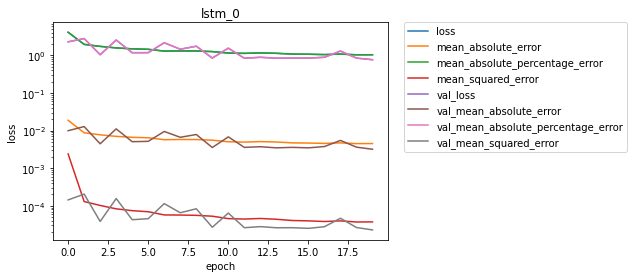

{'units': [256, 256, 32], 'dropout': 0.2, 'loss': 'mean_absolute_percentage_error', 'batch_size': 128, 'epochs': 20, 'tic': 'ALL'}


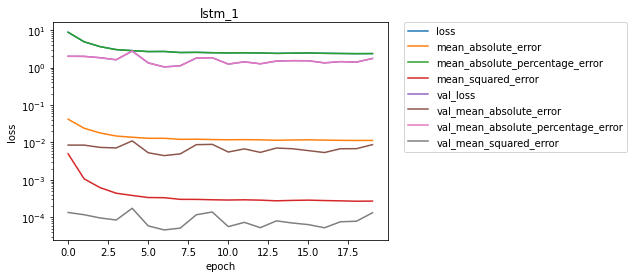

{'units': [256, 256, 32], 'dropout': None, 'loss': 'mean_squared_error', 'batch_size': 128, 'epochs': 20, 'tic': 'ALL'}


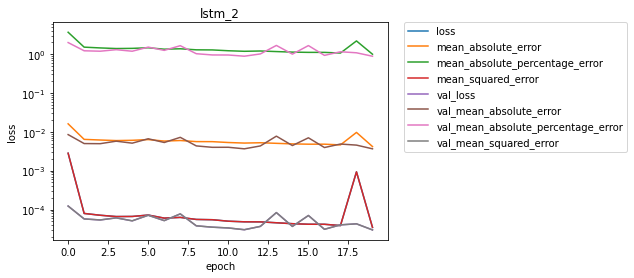

{'units': [256, 256, 32], 'dropout': None, 'loss': 'huber_loss', 'batch_size': 128, 'epochs': 20, 'tic': 'ALL'}


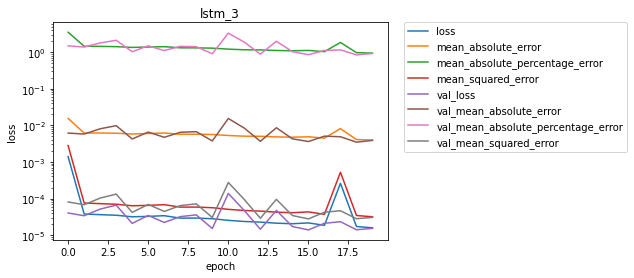

{'units': [256, 256, 32], 'dropout': None, 'loss': 'log_cosh', 'batch_size': 128, 'epochs': 20, 'tic': 'ALL'}


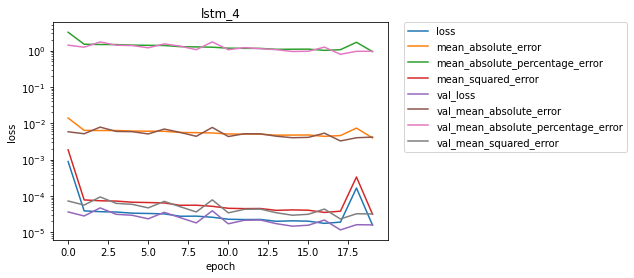

{'units': [256, 256, 32], 'dropout': None, 'loss': 'mean_absolute_percentage_error', 'batch_size': 32, 'epochs': 20, 'tic': 'ALL'}


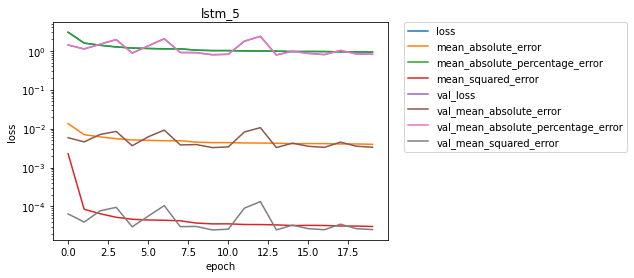

{'units': [256, 256, 32], 'dropout': None, 'loss': 'mean_absolute_percentage_error', 'batch_size': 128, 'epochs': 20, 'tic': 'SPY'}


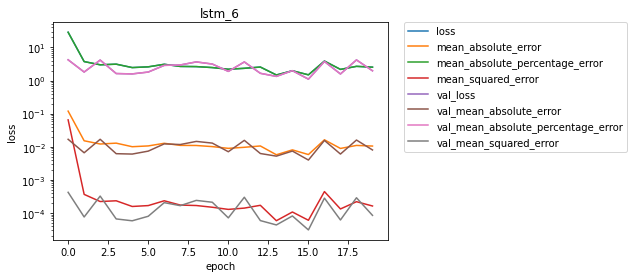

{'units': [128, 128, 32], 'dropout': None, 'loss': 'mean_absolute_percentage_error', 'batch_size': 128, 'epochs': 20, 'tic': 'ALL'}


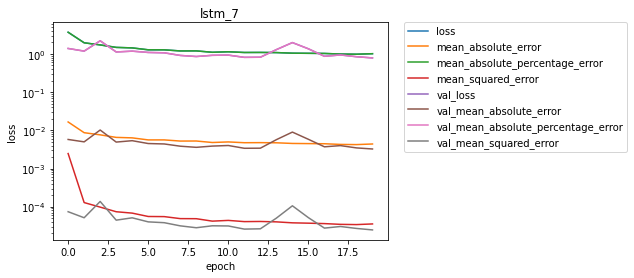

{'units': [256, 256, 64], 'dropout': None, 'loss': 'mean_absolute_percentage_error', 'batch_size': 128, 'epochs': 20, 'tic': 'ALL'}


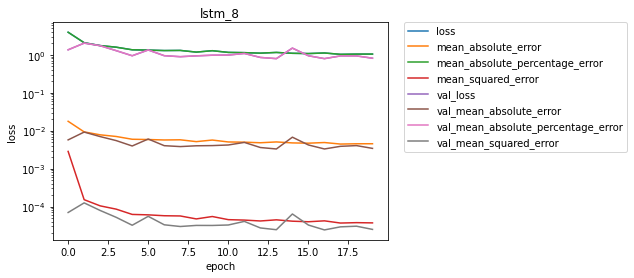

{'units': [512, 512, 64], 'dropout': None, 'loss': 'mean_absolute_percentage_error', 'batch_size': 128, 'epochs': 20, 'tic': 'ALL'}


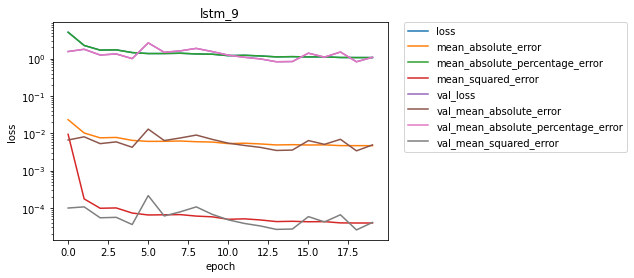

In [276]:
%matplotlib inline

def display_models(model_list):
    df = pd.DataFrame(columns=['model_name'] + list(model_list[0]['history'].history.keys()))
    for model in model_list:
        print(model['model_descr'])
        plot_history(model['model_name'], model['history'], df)
    return df
ret_df = display_models(model_list)

### Metrics Comparison

We compare 10 different model's different metrics include loss, mean absolute error, mean absolute percentage error, mean squared error.

In [106]:
ret_df

,model_name,loss,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_absolute_percentage_error,val_mean_squared_error
1,lstm_0,1.052367,0.004578,1.052367,0.000038,0.972073,0.004099,0.972073,0.000032
2,lstm_1,2.371855,0.011330,2.371855,0.000271,1.535101,0.007442,1.535101,0.000095
3,lstm_2,0.000336,0.006153,1.412530,0.000336,0.000038,0.004355,1.036787,0.000038
4,lstm_3,0.000098,0.005407,1.253396,0.000196,0.000017,0.004077,0.974119,0.000035
5,lstm_4,0.000066,0.005286,1.226172,0.000133,0.000015,0.003798,0.898953,0.000029
6,lstm_5,0.935923,0.004015,0.935923,0.000031,0.888290,0.003789,0.888290,0.000029
7,lstm_6,2.464035,0.010135,2.464035,0.000172,2.582896,0.010011,2.582896,0.000145
8,lstm_7,0.995828,0.004298,0.995828,0.000035,0.856291,0.003565,0.856291,0.000027
9,lstm_8,1.039690,0.004502,1.039690,0.000037,0.895130,0.003783,0.895130,0.000028
10,lstm_9,1.074033,0.004663,1.074033,0.000039,1.143134,0.005058,1.143134,0.000044


lstm model 5 mean absolute percentage error is the best, we could try to do some testing base on trained model

## Analysis and Prediction

In [92]:
def retrain(x_train, y_train, model, batch_size=1, epochs=1):
    history = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs)
    return history

def inverse_transform_y(y_data, scaler, y_col_idx):
    a = np.zeros(shape=(len(y_data), scaler.scale_.shape[0]))
    a[:,y_col_idx]=y_data[:,0]
    return np.exp(scaler.inverse_transform(a)[:,0])

def predict(x, y_val, model):
    y = model.predict(x)
    return y

Select SPY as the sp index represent ticker, and trying to use model predict SPY ticker

From above result list, lstm_5 performance well in training list, let's try to use this model predict as following.

### Model Prediction

The above models already capture all tickers pattern. However, to fit one ticker better with above model, clone an model, and use SPY ticker training dataset to retrain the clone model. Hre we predict and inverse transform prediction to real price

In [232]:
def predict_and_transform(x_train, y_train, x_test, y_test, model):
    # retrain(x_train, y_train, model, batch_size=32, epochs=10)
    
    y_train_predict = predict(x_train, y_train, model)
    y_test_predict = predict(x_test, y_test, model)

    train_predict = inverse_transform_y(y_train_predict, scalers['SPY'], y_col_idx=0)
    train_val = inverse_transform_y(np.reshape(y_train, (y_train.shape[0], 1 )), scalers['SPY'], y_col_idx=0)
    test_predict = inverse_transform_y(y_test_predict, scalers['SPY'], y_col_idx=0)
    test_val = inverse_transform_y(np.reshape(y_test, (y_test.shape[0], 1 )), scalers['SPY'], y_col_idx=0)
    
    return train_predict, train_val, test_predict, test_val

In [233]:
train_predict, train_val, test_predict, test_val = predict_and_transform(x_train_dict['SPY'], y_train_dict['SPY'], x_test_dict['SPY'], y_test_dict['SPY'], model_list[5]['model'])

### Prediction Result

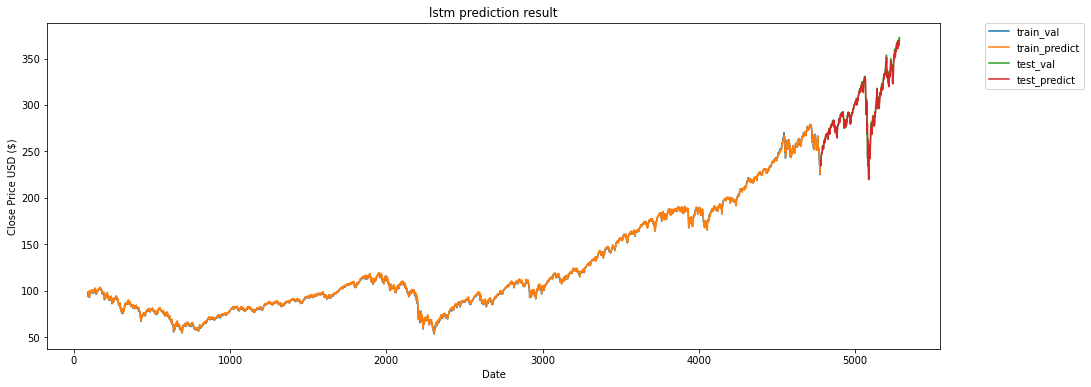

In [241]:
%matplotlib inline

def display_price_results(train_predict, train_val, test_predict, test_val, title):
    train = SPY[input_width + shift - 1 : len(x_train) + input_width + shift - 1].copy()
    train['predict']=train_predict
    train['val']=train_val
    valid = SPY[len(x_train) + input_width + shift - 1 :].copy()
    valid['predict'] = test_predict
    valid['val']=test_val
    
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title(title)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Close Price USD ($)', fontsize=10)
    plt.plot(train['val'], label='train_val')
    plt.plot(train['predict'], label='train_predict')
    plt.plot(valid['val'], label='test_val')
    plt.plot(valid['predict'], label='test_predict')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
display_price_results(train_predict, train_val, test_predict, test_val, 'lstm prediction result')

## Stock Trading

### Trading Strategy

A simple strategy base on the prediction result:
- condition1: if predict price lower than current price, hold cash
- condition2: if predict price higher than or equal to current price, hold a levaraged share

In [270]:
def trading(prev_price, real_price, predict_price, leverage):
    """
    Trading Logic
    """
    prev_portfolio = 1.0
    records = []
    for i in range(len(real_price)):
        if predict_price[i] > prev_price[i]:
            portfolio = prev_portfolio * (leverage * (real_price[i] / prev_price[i] - 1) + 1)
        else:
            portfolio = prev_portfolio
        prev_portfolio = portfolio
        records.append(prev_portfolio)
    return records

In [277]:
def gen_prev_price(begin_price, real_price):
    """
    Generate One Previous Value Point
    """
    prev_price=real_price.copy()[:-1]
    return np.insert(prev_price, 0, begin_price)


In [279]:
prev_val = gen_prev_price(train_val[-1], test_val)
records_no_leverage=trading(prev_val, test_val, test_predict, leverage=1)
records_leverage_1=trading(prev_val, test_val, test_predict, leverage=2)

### Trading Performance

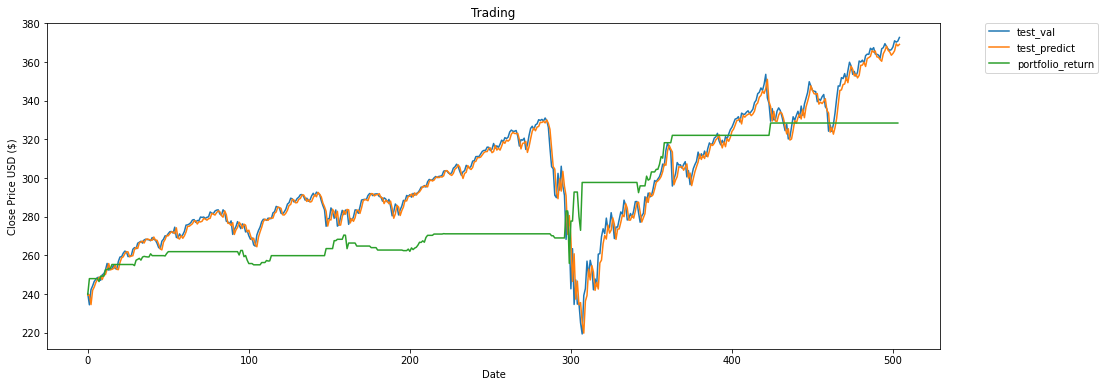

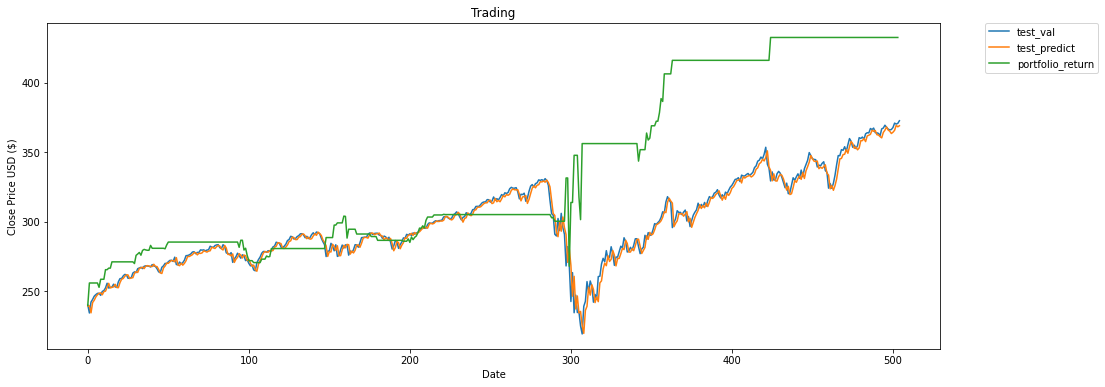

In [280]:
%matplotlib inline

def plot_trading_perform(test_val, test_predict, prev_val, records):
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('Trading')
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Close Price USD ($)', fontsize=10)
    plt.plot(test_val, label='test_val')

    plt.plot(test_predict, label='test_predict')
    plt.plot(prev_val[0]*np.array(records[1:]), label='portfolio_return')
    # plt.plot(train[['val','predict']])
    # plt.plot(valid[['val','predict']])
    # plt.legend(['Train', 'Train_Predict' 'Test', 'Test_Predict'], loc='lower right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    
plot_trading_perform(test_val, test_predict, prev_val, records_no_leverage)
plot_trading_perform(test_val, test_predict, prev_val, records_leverage_1)

### Backtest

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (504, 8)


Start date,2019-01-02
End date,2020-12-30
Total months,24
,Backtest
Annual return,16.985%
Cumulative returns,36.854%
Annual volatility,13.994%
Sharpe ratio,1.19
Calmar ratio,1.78
Stability,0.88
Max drawdown,-9.568%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.57,2020-03-11,2020-03-12,2020-03-17,5
1,6.76,2020-03-19,2020-03-23,2020-03-24,4
2,3.11,2019-08-21,2019-10-18,2019-11-08,58
3,2.82,2019-05-22,2019-06-03,2019-08-06,55
4,1.77,2020-05-12,2020-05-13,2020-05-20,7


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.07%,-9.57%,9.06%


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


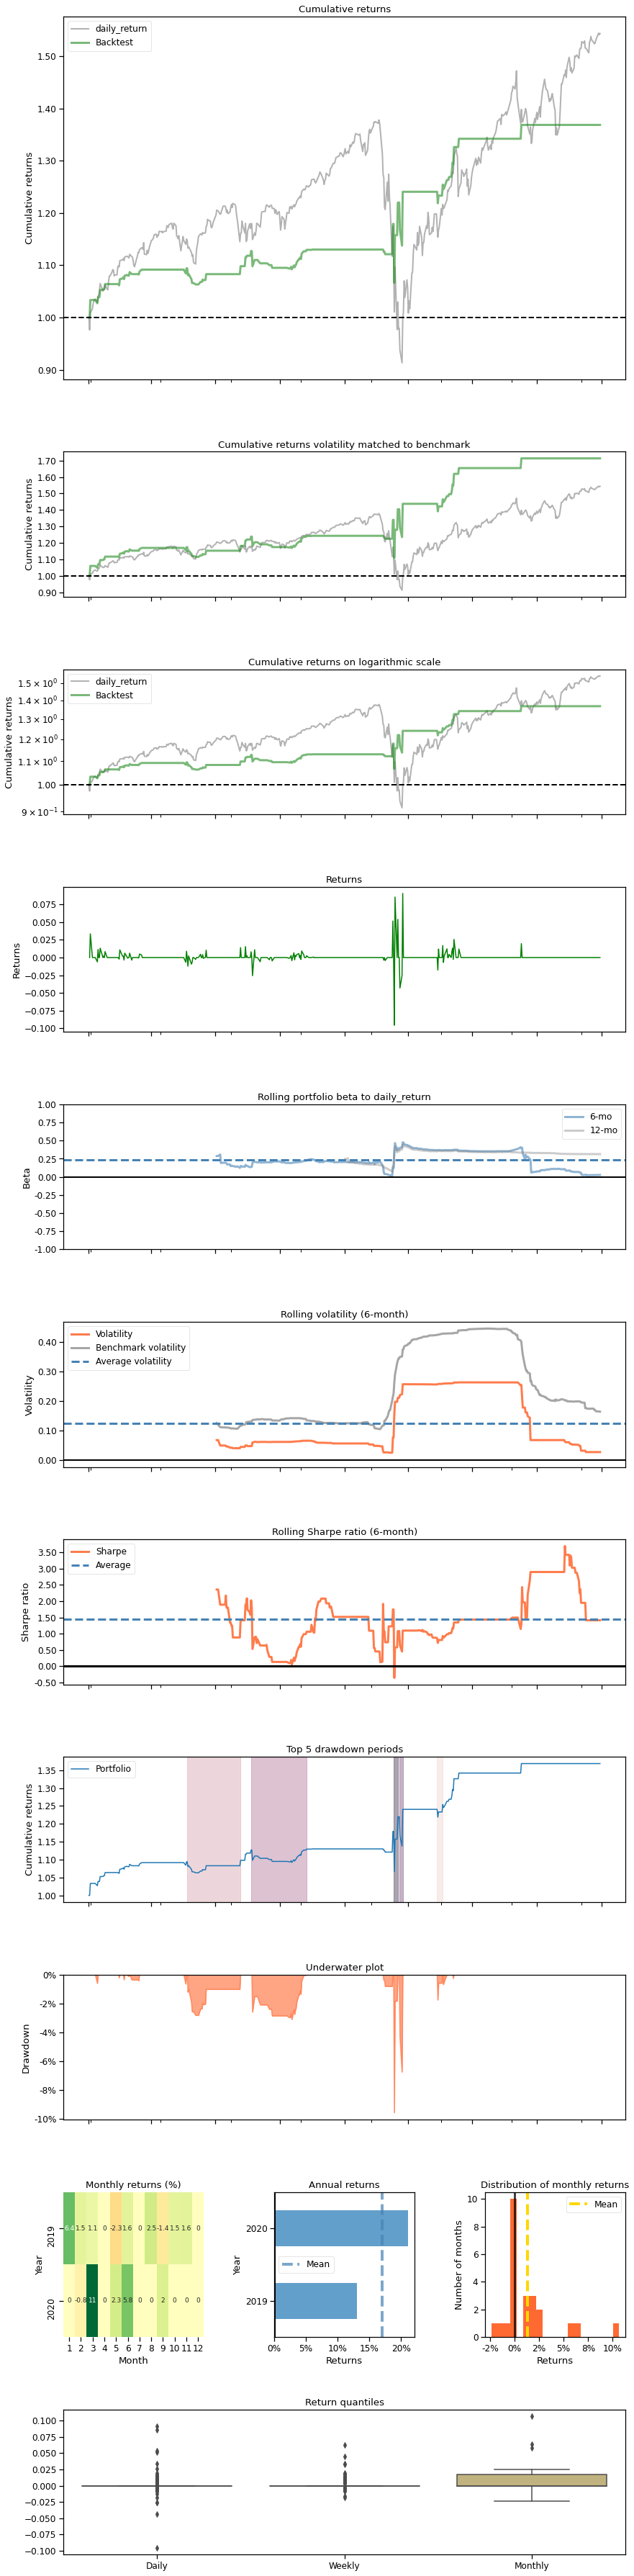

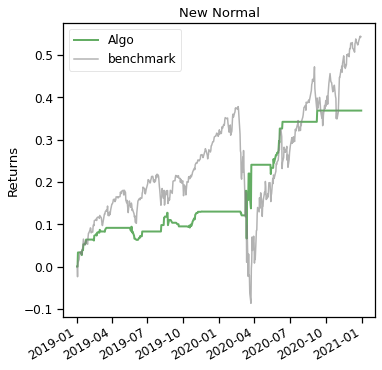

In [281]:
backtest_spy = SPY[len(x_train) + input_width + shift - 1 :].copy()
backtest_spy['account_value']=records_no_leverage
backtest_plot(backtest_spy, baseline_ticker = 'SPY', baseline_start = '2019-01-02', baseline_end = '2020-12-31')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (504, 8)


Start date,2019-01-02
End date,2020-12-30
Total months,24
,Backtest
Annual return,34.245%
Cumulative returns,80.216%
Annual volatility,27.988%
Sharpe ratio,1.19
Calmar ratio,1.79
Stability,0.88
Max drawdown,-19.135%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.14,2020-03-11,2020-03-12,2020-03-17,5
1,13.29,2020-03-19,2020-03-23,2020-03-24,4
2,6.21,2019-08-21,2019-10-18,2019-11-08,58
3,5.60,2019-05-22,2019-06-03,2019-08-06,55
4,3.54,2020-05-12,2020-05-13,2020-05-20,7


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.13%,-19.14%,18.12%


D:\InstalledSoftware\anaconda3\envs\py37-python-notebook\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


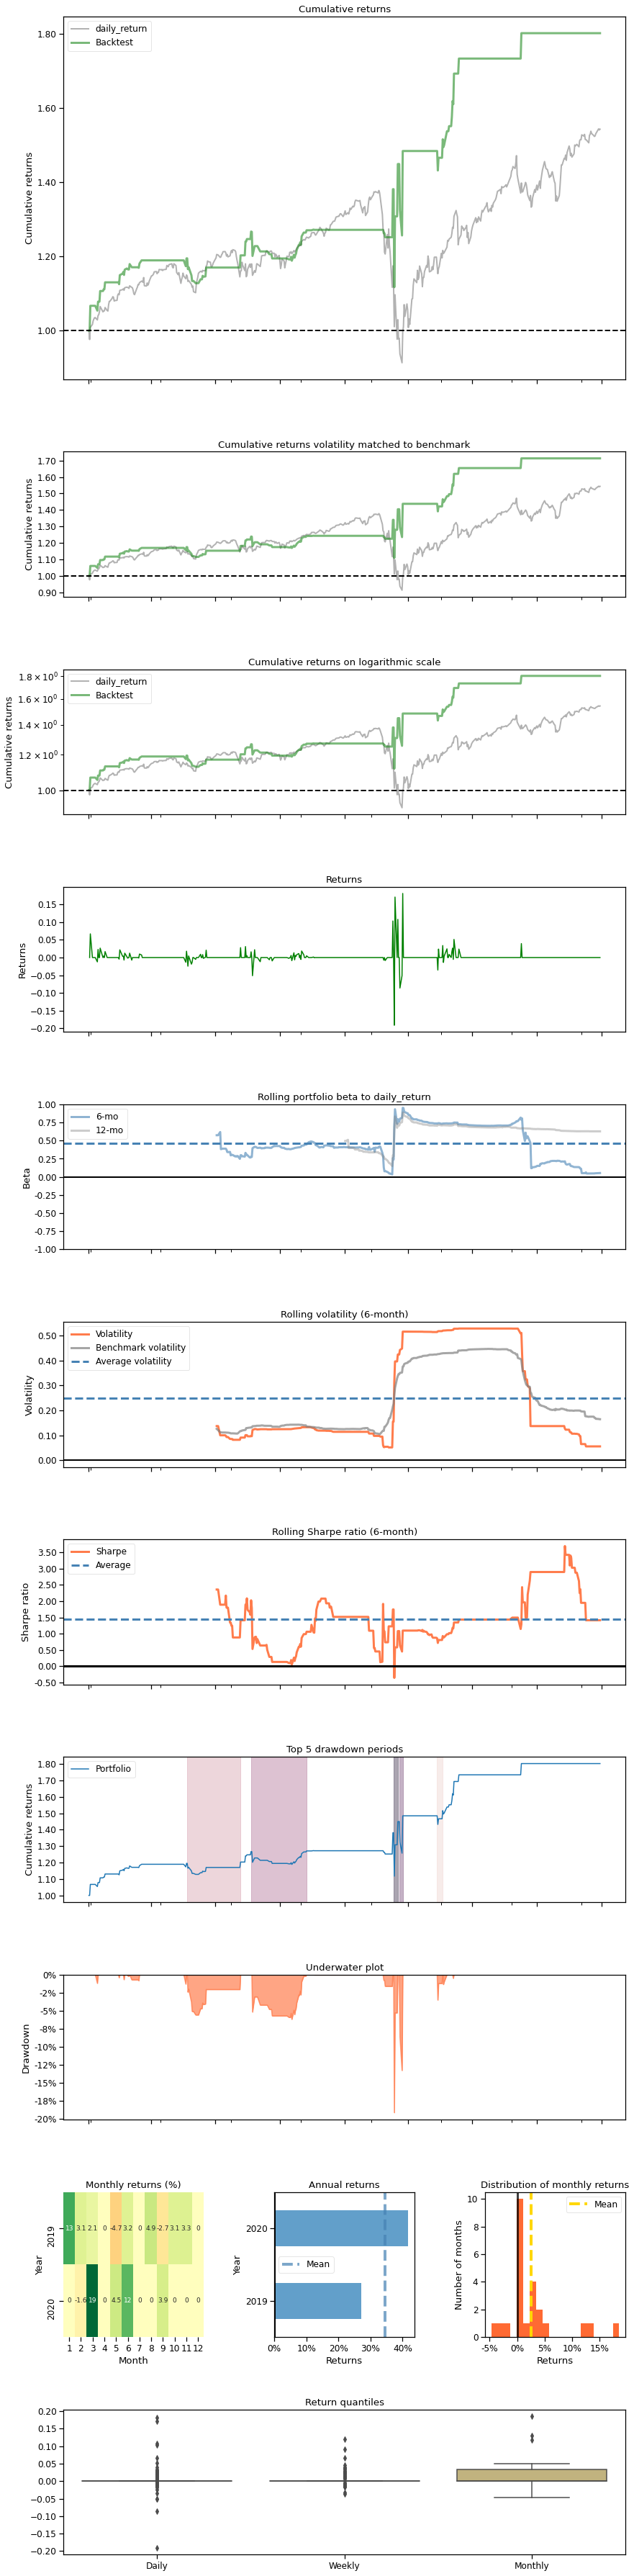

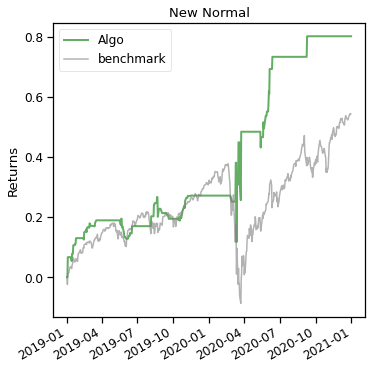

In [282]:
backtest_spy = SPY[len(x_train) + input_width + shift - 1 :].copy()
backtest_spy['account_value']=records_leverage_1
backtest_plot(backtest_spy, baseline_ticker = 'SPY', baseline_start = '2019-01-02', baseline_end = '2020-12-31')